In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
pip install opencv-python

In [2]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.8 MB/s eta 0:00:00


In [34]:
import cv2
import numpy as np
from ultralytics import YOLO
from ultralytics.solutions import ObjectCounter


In [35]:
MODEL_PATH = "/content/drive/MyDrive/Train model/best.pt"
VIDEO_PATH = "/content/drive/MyDrive/cctv.mp4/market.mp4"
OUTPUT_PATH = "/content/output_with_counting.mp4"

model = YOLO(MODEL_PATH)


Video setup

In [45]:
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise FileNotFoundError("Video not found")

w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

writer = cv2.VideoWriter(
    OUTPUT_PATH,
    cv2.VideoWriter_fourcc(*"mp4v"),
    fps,
    (w, h)
)


Entry Exit

In [46]:
frame_idx = 0

first_seen = {}        # id → frame index first seen
last_seen = {}         # id → frame index last seen
counted_entry = set()
counted_exit = set()

MIN_FRAMES_TO_COUNT = 8     #  must stay visible
EXIT_TIMEOUT = 20           #  must be gone


LOOP / Logic

In [48]:
while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_idx += 1

    results = model.track(
        frame,
        persist=True,
        tracker="bytetrack.yaml",
        conf=0.4,
        iou=0.5
    )

    visible_ids = set()

    if results[0].boxes.id is not None:
        boxes = results[0].boxes.xyxy.cpu().numpy()
        ids = results[0].boxes.id.cpu().numpy()
        classes = results[0].boxes.cls.cpu().numpy()

        for box, tid, cls in zip(boxes, ids, classes):
            tid = int(tid)
            visible_ids.add(tid)

            if tid not in first_seen:
                first_seen[tid] = frame_idx

            last_seen[tid] = frame_idx

            # -------------------------
            # ENTRY (STABLE)
            # -------------------------
            if (
                tid not in counted_entry and
                frame_idx - first_seen[tid] >= MIN_FRAMES_TO_COUNT
            ):
                counted_entry.add(tid)

            # Gender (FIXED)
            gender = class_names[int(cls)] # Changed CLASS_NAMES to class_names

            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(
                frame,
                f"ID {tid} {gender}",
                (x1, y1 - 8),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.6,
                (0, 255, 0),
                2
            )

    # -------------------------
    # EXIT (STABLE)
    # -------------------------
    for tid in counted_entry:
        if (
            tid not in visible_ids and
            tid not in counted_exit and
            frame_idx - last_seen.get(tid, 0) >= EXIT_TIMEOUT
        ):
            counted_exit.add(tid)

    entered = len(counted_entry)
    exited = len(counted_exit)
    current = entered - exited

    cv2.putText(
        frame,
        f"Entered: {entered}   Exited: {exited}   Current: {current}",
        (30, 40),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 0, 255),
        3
    )

    writer.write(frame)


Streaming output truncated to the last 5000 lines.
0: 640x480 1 female, 1 male, 176.9ms
Speed: 4.8ms preprocess, 176.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 female, 1 male, 180.3ms
Speed: 5.2ms preprocess, 180.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 female, 1 male, 187.1ms
Speed: 12.9ms preprocess, 187.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 female, 1 male, 176.6ms
Speed: 4.5ms preprocess, 176.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 female, 1 male, 171.8ms
Speed: 5.7ms preprocess, 171.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 female, 1 male, 174.1ms
Speed: 4.9ms preprocess, 174.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 female, 181.1ms
Speed: 4.8ms preprocess, 181.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)

0: 6

In [50]:
cap.release()
writer.release()
cv2.destroyAllWindows()

print("/content/output_with_counting.mp4", OUTPUT_PATH)


/content/output_with_counting.mp4 /content/output_with_counting.mp4


In [59]:
import time, os
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [60]:
# Parameters
HEATMAP_DOWNSAMPLE = 2

# These must already exist from earlier cells
# VIDEO_PATH
# model
# fps
# MIN_FRAMES_TO_COUNT
# EXIT_TIMEOUT

cap2 = cv2.VideoCapture(VIDEO_PATH)
if not cap2.isOpened():
    raise FileNotFoundError("Video not found for heatmap generation")

w2 = int(cap2.get(cv2.CAP_PROP_FRAME_WIDTH))
h2 = int(cap2.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames = int(cap2.get(cv2.CAP_PROP_FRAME_COUNT))
fps_local = int(cap2.get(cv2.CAP_PROP_FPS)) if cap2.get(cv2.CAP_PROP_FPS) > 0 else fps


Initialize Tracking & Heatmap State

In [61]:
H = np.zeros((h2, w2), dtype=np.float32)

times = []
total_dets = 0
frame_idx2 = 0

# Tracking state
first_seen2 = {}
last_seen2 = {}
counted_entry2 = set()
counted_exit2 = set()
entries_per_second = {}
exits_per_second = {}
seen_ids = set()

MIN_FRAMES = MIN_FRAMES_TO_COUNT
EXIT_TIMEOUT = EXIT_TIMEOUT


Main Loop (Tracking + Heatmap + Entry/Exit)

In [62]:
while True:
    ret, frame = cap2.read()
    if not ret:
        break

    frame_idx2 += 1
    t0 = time.time()

    results = model.track(
        frame,
        persist=True,
        tracker="bytetrack.yaml",
        conf=0.4,
        iou=0.5
    )

    t1 = time.time()
    times.append(t1 - t0)

    visible_ids = set()

    if results[0].boxes.xyxy is not None:
        boxes = results[0].boxes.xyxy.cpu().numpy()
        ids = (
            results[0].boxes.id.cpu().numpy()
            if results[0].boxes.id is not None
            else np.array([])
        )

        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = map(int, box)
            cx = (x1 + x2) // 2
            cy = (y1 + y2) // 2

            if 0 <= cy < h2 and 0 <= cx < w2:
                H[cy, cx] += 1

            total_dets += 1

            if i < len(ids):
                tid = int(ids[i])
                visible_ids.add(tid)
                seen_ids.add(tid)

                if tid not in first_seen2:
                    first_seen2[tid] = frame_idx2
                last_seen2[tid] = frame_idx2

                if (
                    tid not in counted_entry2
                    and frame_idx2 - first_seen2[tid] >= MIN_FRAMES
                ):
                    counted_entry2.add(tid)
                    sec = frame_idx2 // fps_local
                    entries_per_second[sec] = entries_per_second.get(sec, 0) + 1

    # EXIT detection
    for tid in list(counted_entry2):
        if (
            tid not in visible_ids
            and tid not in counted_exit2
            and frame_idx2 - last_seen2.get(tid, 0) >= EXIT_TIMEOUT
        ):
            counted_exit2.add(tid)
            sec = frame_idx2 // fps_local
            exits_per_second[sec] = exits_per_second.get(sec, 0) + 1

cap2.release()


Streaming output truncated to the last 5000 lines.
0: 640x480 1 female, 1 male, 183.4ms
Speed: 6.5ms preprocess, 183.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 female, 1 male, 179.6ms
Speed: 6.6ms preprocess, 179.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 female, 1 male, 189.5ms
Speed: 7.9ms preprocess, 189.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 female, 1 male, 284.0ms
Speed: 6.0ms preprocess, 284.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 female, 1 male, 267.6ms
Speed: 10.2ms preprocess, 267.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 female, 1 male, 269.7ms
Speed: 9.0ms preprocess, 269.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 female, 272.8ms
Speed: 10.2ms preprocess, 272.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

0: 

Timing & Performance Stats

In [63]:
total_time = sum(times) if times else 1e-6
approx_fps = frame_idx2 / total_time if total_time > 0 else 0
avg_time = np.mean(times) if times else 0
p95 = np.percentile(times, 95) if times else 0

print(
    f"Frames: {frame_idx2}, "
    f"Total detections: {total_dets}, "
    f"FPS_processed: {approx_fps:.2f}, "
    f"avg_time: {avg_time:.3f}s, "
    f"p95: {p95:.3f}s"
)


Frames: 1814, Total detections: 5663, FPS_processed: 4.13, avg_time: 0.242s, p95: 0.324s


Lightweight Tracker Wrapper

In [64]:
class SimpleTracker:
    def __init__(self, first_seen, last_seen, seen_ids):
        self.first_seen = first_seen
        self.last_seen = last_seen
        self.nextObjectID = max(seen_ids) + 1 if seen_ids else 0

    def get_gender(self, oid):
        return None


Summary Dictionary

In [65]:
trk = SimpleTracker(first_seen2, last_seen2, seen_ids)

summary = {
    "total_frames": frame_idx2,
    "total_detections": total_dets,
    "unique_ids": len(seen_ids),
    "approx_fps": approx_fps,
    "entries_per_second": entries_per_second,
    "exits_per_second": exits_per_second,
    "heatmap_raw": H,
    "tracker": trk
}


Entry / Exit Per-Second Plot

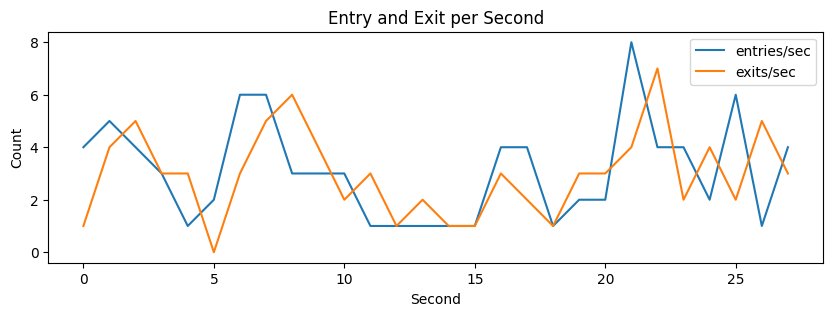

In [66]:
secs = sorted(
    set(summary["entries_per_second"].keys())
    | set(summary["exits_per_second"].keys())
)

entries = [summary["entries_per_second"].get(s, 0) for s in secs]
exits = [summary["exits_per_second"].get(s, 0) for s in secs]

plt.figure(figsize=(10, 3))
plt.plot(secs, entries, label="entries/sec")
plt.plot(secs, exits, label="exits/sec")
plt.xlabel("Second")
plt.ylabel("Count")
plt.legend()
plt.title("Entry and Exit per Second")
plt.show()


Heatmap Visualization

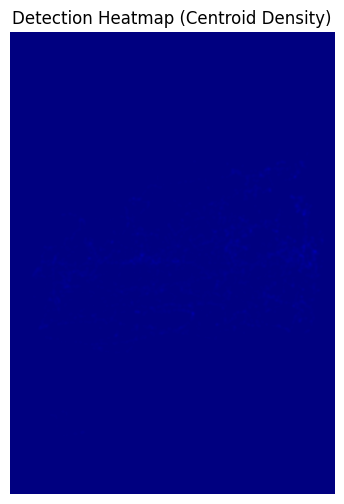

In [67]:
heat = summary["heatmap_raw"]

heat_norm = cv2.normalize(heat, None, 0, 255, cv2.NORM_MINMAX).astype("uint8")
heat_blur = cv2.GaussianBlur(heat_norm, (0, 0), sigmaX=3, sigmaY=3)
heat_col = cv2.applyColorMap(heat_blur, cv2.COLORMAP_JET)

heat_up = cv2.resize(
    heat_col,
    (heat.shape[1] * HEATMAP_DOWNSAMPLE,
     heat.shape[0] * HEATMAP_DOWNSAMPLE)
)

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(heat_up, cv2.COLOR_BGR2RGB))
plt.title("Detection Heatmap (Centroid Density)")
plt.axis("off")
plt.show()


Summary Matrix / Track Durations

In [68]:
print("Total frames:", summary["total_frames"])
print("Total detections:", summary["total_detections"])
print("Unique tracked IDs:", summary["unique_ids"])
print(f"Approx FPS: {summary['approx_fps']:.2f}")

trk = summary["tracker"]
durations = []

for oid in range(trk.nextObjectID):
    if oid in trk.first_seen and oid in trk.last_seen:
        durations.append(
            (oid,
             trk.last_seen[oid] - trk.first_seen[oid] + 1,
             trk.get_gender(oid))
        )

durations.sort(key=lambda x: x[1], reverse=True)

print("Top tracks (id, duration_frames, gender):")
print(durations[:10])


Total frames: 1814
Total detections: 5663
Unique tracked IDs: 144
Approx FPS: 4.13
Top tracks (id, duration_frames, gender):
[(800, 571, None), (836, 518, None), (789, 513, None), (742, 255, None), (823, 230, None), (701, 218, None), (878, 208, None), (882, 193, None), (855, 175, None), (751, 171, None)]
